<a href="https://colab.research.google.com/github/thimotyb/real-world-machine-learning/blob/python3/Using_ML_Regressors_for_Time_Series_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Time Series Analysis with Machine Learning Regressors


We begin with a simple [definition](https://en.wikipedia.org/wiki/Time_series) of time series:
> *Time series* is a series of data points indexed (or listed or graphed) in time order.

Therefore, the data is organized by relatively deterministic timestamps, and may, compared to random sample data, contain additional information that we can extract.

In [0]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook



%matplotlib inline

In [0]:
# Import Ads dataset
ads = pd.read_csv('https://raw.githubusercontent.com/thimotyb/real-world-machine-learning/python3/time-series/ads.csv', index_col=['Time'], parse_dates=['Time'])


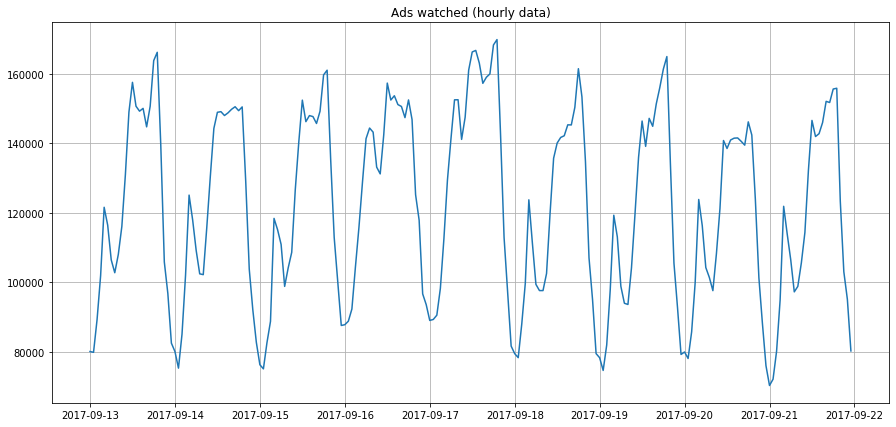

In [3]:
plt.figure(figsize=(15, 7))
plt.plot(ads.Ads)
plt.title('Ads watched (hourly data)')
plt.grid(True)
plt.show()

## Forecast quality metrics

Before we begin forecasting, let's understand how to measure the quality of our predictions and take a look at the most commonly used metrics.

- [R squared](http://scikit-learn.org/stable/modules/model_evaluation.html#r2-score-the-coefficient-of-determination): coefficient of determination (in econometrics, this can be interpreted as the percentage of variance explained by the model), $(-\infty, 1]$

$R^2 = 1 - \frac{SS_{res}}{SS_{tot}}$ 

```python
sklearn.metrics.r2_score
```
---
- [Mean Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-absolute-error): this is an interpretable metric because it has the same unit of measurment as the initial series, $[0, +\infty)$

$MAE = \frac{\sum\limits_{i=1}^{n} |y_i - \hat{y}_i|}{n}$ 

```python
sklearn.metrics.mean_absolute_error
```
---
- [Median Absolute Error](http://scikit-learn.org/stable/modules/model_evaluation.html#median-absolute-error): again, an interpretable metric that is particularly interesting because it is robust to outliers, $[0, +\infty)$

$MedAE = median(|y_1 - \hat{y}_1|, ... , |y_n - \hat{y}_n|)$

```python
sklearn.metrics.median_absolute_error
```
---
- [Mean Squared Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-error): the most commonly used metric that gives a higher penalty to large errors and vice versa, $[0, +\infty)$

$MSE = \frac{1}{n}\sum\limits_{i=1}^{n} (y_i - \hat{y}_i)^2$

```python
sklearn.metrics.mean_squared_error
```
---
- [Mean Squared Logarithmic Error](http://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-logarithmic-error): practically, this is the same as MSE, but we take the logarithm of the series. As a result, we give more weight to small mistakes as well. This is usually used when the data has exponential trends, $[0, +\infty)$

$MSLE = \frac{1}{n}\sum\limits_{i=1}^{n} (log(1+y_i) - log(1+\hat{y}_i))^2$

```python
sklearn.metrics.mean_squared_log_error
```
---
- Mean Absolute Percentage Error: this is the same as MAE but is computed as a percentage, which is very convenient when you want to explain the quality of the model to management, $[0, +\infty)$

$MAPE = \frac{100}{n}\sum\limits_{i=1}^{n} \frac{|y_i - \hat{y}_i|}{y_i}$ 

```python
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
```

In [0]:
# Importing everything from above

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Using ML for Time Series Prediction

We select a few features from the existing time series and build a simple linear regression model or, say, a random forest.

The model needs features, and all we have is a 1-dimentional time series. What features can we exctract? 
* Lags of time series
* Window statistics:
    - Max/min value of series in a window
    - Average/median value in a window
    - Window variance
    - etc.
* Date and time features:
    - Minute of an hour, hour of a day, day of the week, and so on
    - Is this day a holiday? Maybe there is a special event? Represent that as a boolean feature
* Target encoding 
* Forecasts from other models (note that we can lose the speed of prediction this way)